# Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed for this project.

In [1]:
# 基础库导入
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 深度学习框架
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 图像处理
from PIL import Image
import nibabel as nib
from scipy.ndimage import zoom

# 评估指标
from sklearn.metrics import accuracy_score

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 设置随机种子保证结果可重复
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("所有包导入成功！")

Using device: cpu
所有包导入成功！


## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which are like pixels in 2D images. Here, try to visualise the axial plane (which usually has higher resolution) of some of the volumes and the corresponding segmentation maps.

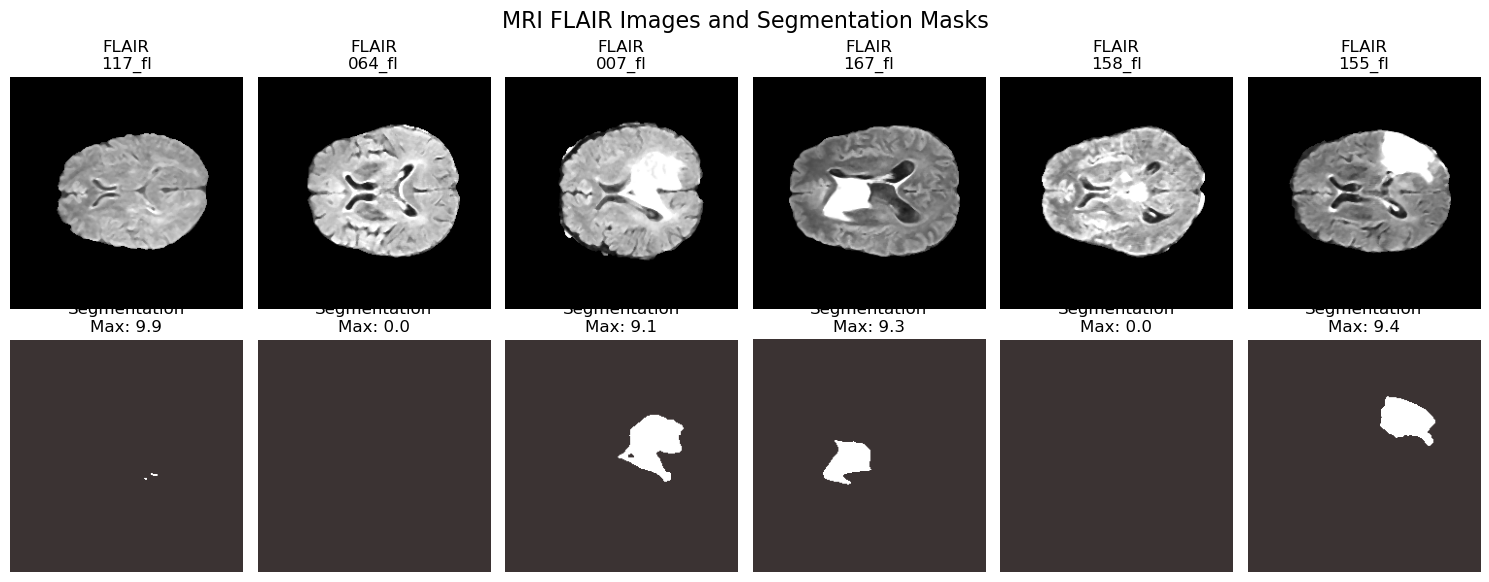


数据概览:
找到 210 个FLAIR文件
图像尺寸: (240, 240, 155)
数据范围: -0.448 到 3.265


In [2]:
# 设置数据路径
DATA_PATH = "/Users/dd/Desktop/DSI Summer School Project tutorial CV/dataset_segmentation/train"

def visualize_mri_and_segmentation(data_path, num_samples=6):
    """
    可视化MRI切片和对应的分割蒙版
    """
    # 获取所有的FLAIR文件
    flair_files = glob.glob(os.path.join(data_path, "*_fla_proc.npy"))
    
    # 随机选择几个文件
    selected_files = random.sample(flair_files, min(num_samples, len(flair_files)))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('MRI FLAIR Images and Segmentation Masks', fontsize=16)
    
    for i, flair_path in enumerate(selected_files):
        # 加载FLAIR图像
        flair_data = np.load(flair_path)
        
        # 构造对应的分割文件路径
        seg_path = flair_path.replace("_fla_proc.npy", "_seg_proc.npy")
        
        if os.path.exists(seg_path):
            seg_data = np.load(seg_path)
            
            # 选择中间切片
            slice_idx = flair_data.shape[2] // 2
            flair_slice = flair_data[:, :, slice_idx]
            seg_slice = seg_data[:, :, slice_idx]
            
            # 显示FLAIR图像
            axes[0, i].imshow(flair_slice, cmap='gray')
            axes[0, i].set_title(f'FLAIR\n{os.path.basename(flair_path)[:6]}')
            axes[0, i].axis('off')
            
            # 显示分割蒙版
            axes[1, i].imshow(seg_slice, cmap='hot', alpha=0.8)
            axes[1, i].set_title(f'Segmentation\nMax: {seg_slice.max():.1f}')
            axes[1, i].axis('off')
        else:
            print(f"分割文件不存在: {seg_path}")
    
    plt.tight_layout()
    plt.show()
    
    # 打印数据信息
    print(f"\n数据概览:")
    print(f"找到 {len(flair_files)} 个FLAIR文件")
    if flair_files:
        sample_data = np.load(flair_files[0])
        print(f"图像尺寸: {sample_data.shape}")
        print(f"数据范围: {sample_data.min():.3f} 到 {sample_data.max():.3f}")

# 运行可视化
visualize_mri_and_segmentation(DATA_PATH, num_samples=6)

## Data preprocessing (Optional)

Images in the original dataset are usually of different sizes, so sometimes we need to resize and normalise them (z-score is commonly used in preprocessing MRI images) to fit the CNN model. Depending on the images you choose to use for training your model, you may need to apply other preprocessing methods. If preprocessing methods like cropping are applied, remember to convert the segmentation result back to its original size.

创建预处理的训练数据...
处理 50 个文件...


100%|██████████| 50/50 [00:02<00:00, 16.93it/s]


处理完成!
图像数据形状: (50, 256, 256)
蒙版数据形状: (50, 256, 256)
图像数据范围: -0.685 到 3.375
蒙版中有肿瘤的样本: 28 / 50


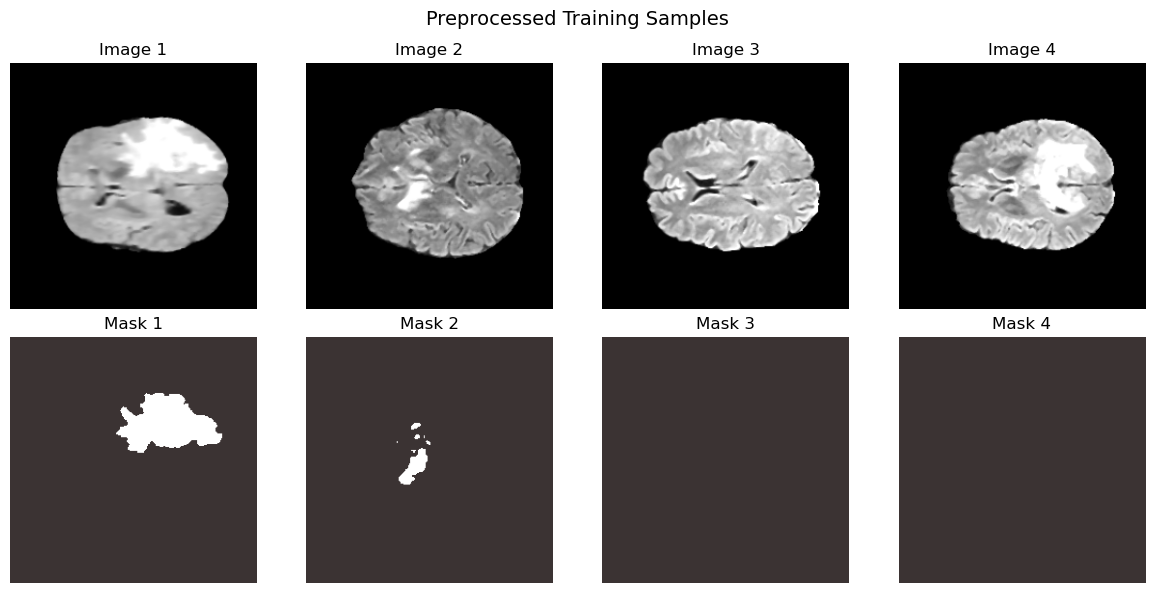

In [3]:
# 数据预处理函数
def preprocess_data(image, mask, target_size=(256, 256)):
    """
    对图像和蒙版进行预处理
    
    Args:
        image: FLAIR图像 (H, W, D)
        mask: 分割蒙版 (H, W, D)
        target_size: 目标尺寸 (H, W)
    
    Returns:
        processed_image: 预处理后的图像
        processed_mask: 预处理后的蒙版
    """
    # 选择中间切片
    slice_idx = image.shape[2] // 2
    img_slice = image[:, :, slice_idx]
    mask_slice = mask[:, :, slice_idx]
    
    # 图像标准化 (Z-score normalization)
    mean = np.mean(img_slice)
    std = np.std(img_slice)
    img_slice = (img_slice - mean) / (std + 1e-8)
    
    # 调整图像尺寸
    from scipy.ndimage import zoom
    
    # 计算缩放因子
    scale_h = target_size[0] / img_slice.shape[0]
    scale_w = target_size[1] / img_slice.shape[1]
    
    # 缩放图像和蒙版
    img_resized = zoom(img_slice, (scale_h, scale_w), order=1)  # 双线性插值
    mask_resized = zoom(mask_slice, (scale_h, scale_w), order=0)  # 最近邻插值
    
    # 将蒙版二值化
    mask_resized = (mask_resized > 0.5).astype(np.float32)
    
    return img_resized, mask_resized

def create_training_data(data_path, target_size=(256, 256), max_samples=None):
    """
    创建训练数据集
    """
    flair_files = glob.glob(os.path.join(data_path, "*_fla_proc.npy"))
    
    if max_samples:
        flair_files = flair_files[:max_samples]
    
    images = []
    masks = []
    
    print(f"处理 {len(flair_files)} 个文件...")
    
    for i, flair_path in enumerate(tqdm(flair_files)):
        # 加载数据
        flair_data = np.load(flair_path)
        seg_path = flair_path.replace("_fla_proc.npy", "_seg_proc.npy")
        
        if os.path.exists(seg_path):
            seg_data = np.load(seg_path)
            
            # 预处理
            img_processed, mask_processed = preprocess_data(
                flair_data, seg_data, target_size
            )
            
            images.append(img_processed)
            masks.append(mask_processed)
    
    images = np.array(images)
    masks = np.array(masks)
    
    print(f"处理完成!")
    print(f"图像数据形状: {images.shape}")
    print(f"蒙版数据形状: {masks.shape}")
    print(f"图像数据范围: {images.min():.3f} 到 {images.max():.3f}")
    print(f"蒙版中有肿瘤的样本: {np.sum(masks.sum(axis=(1,2)) > 0)} / {len(masks)}")
    
    return images, masks

# 创建训练数据 (先处理少量样本测试)
print("创建预处理的训练数据...")
train_images, train_masks = create_training_data(DATA_PATH, target_size=(256, 256), max_samples=50)

# 可视化预处理结果
def show_preprocessed_samples(images, masks, num_samples=4):
    """显示预处理后的样本"""
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    fig.suptitle('Preprocessed Training Samples', fontsize=14)
    
    for i in range(num_samples):
        # 显示图像
        axes[0, i].imshow(images[i], cmap='gray')
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')
        
        # 显示蒙版
        axes[1, i].imshow(masks[i], cmap='hot', alpha=0.8)
        axes[1, i].set_title(f'Mask {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 显示预处理结果
show_preprocessed_samples(train_images, train_masks, num_samples=4)

## Train-time data augmentation
Generalizability is crucial to a deep learning model, and it refers to the performance difference of a model when evaluated on seen data (training data) versus unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimize the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose from in this project, including rotation, shifting, flipping, etc. PyTorch provides excellent data augmentation capabilities through torchvision.transforms, which you can combine with custom transforms for medical imaging.

You are encouraged to try different augmentation methods to get the best segmentation result.


## Get the data generator ready

创建训练集和验证集...
训练集: 40 样本
验证集: 10 样本
训练批次数: 5
验证批次数: 2

测试数据加载器...
批次图像形状: torch.Size([8, 1, 256, 256])
批次蒙版形状: torch.Size([8, 256, 256])
图像数据类型: torch.float32
蒙版数据类型: torch.int64
图像值范围: -0.864 到 3.036
蒙版值范围: 0 到 1


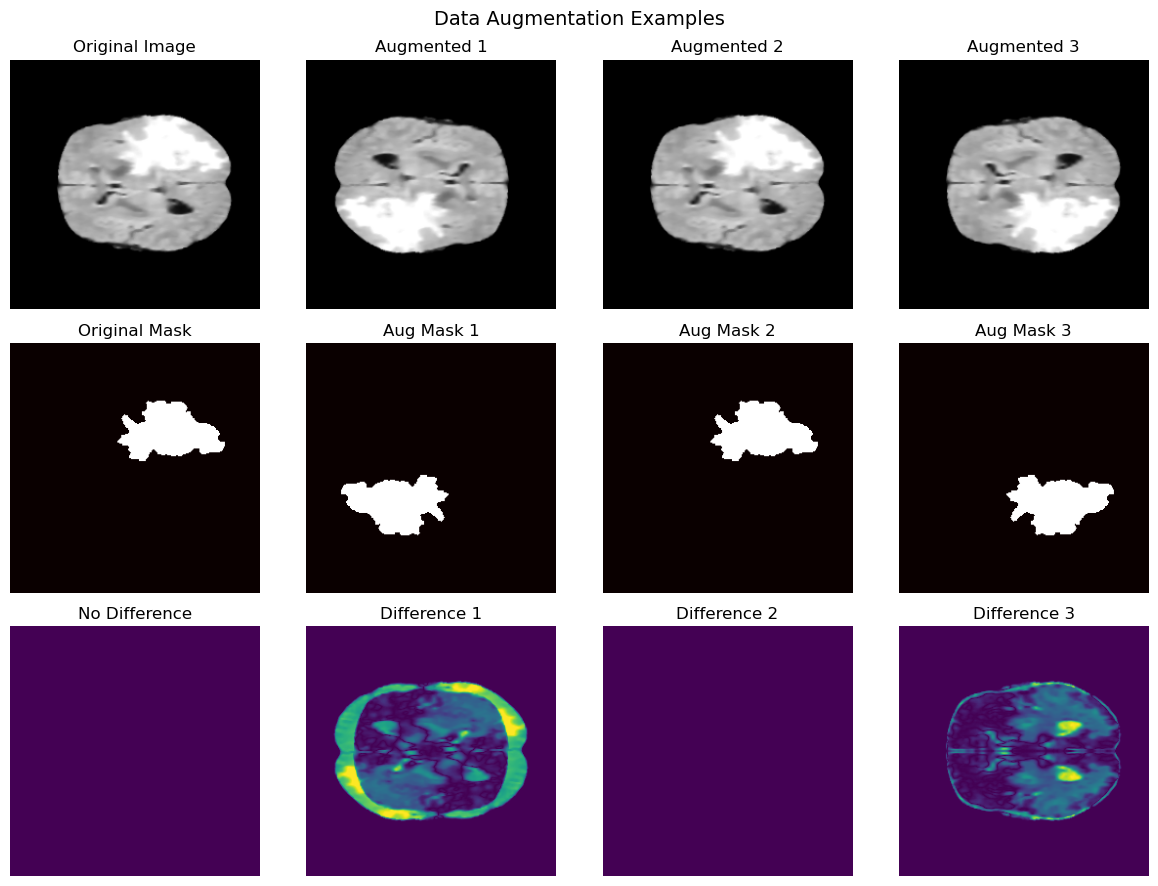

In [4]:
# 数据增强函数
def augment_data(image, mask):
    """
    对图像和蒙版进行数据增强
    """
    # 随机水平翻转
    if random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    
    # 随机垂直翻转
    if random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    
    # 随机旋转（小角度）
    if random.random() > 0.5:
        angle = random.uniform(-10, 10)  # -10到10度
        from scipy.ndimage import rotate
        image = rotate(image, angle, reshape=False, order=1, mode='constant', cval=0)
        mask = rotate(mask, angle, reshape=False, order=0, mode='constant', cval=0)
    
    # 添加随机噪声
    if random.random() > 0.7:
        noise = np.random.normal(0, 0.05, image.shape)
        image = image + noise
    
    return image, mask

# 自定义Dataset类
class BrainSegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()
        
        # 数据增强
        if self.augment:
            image, mask = augment_data(image, mask)
        
        # 转换为PyTorch张量
        # 图像: (1, H, W) - 单通道
        # 蒙版: (H, W) - 标签
        image = torch.FloatTensor(image).unsqueeze(0)  # 添加通道维度
        mask = torch.LongTensor(mask.astype(np.int64))
        
        return image, mask

# 分割训练集和验证集
def split_train_val(images, masks, val_split=0.2):
    """分割数据为训练集和验证集"""
    n_samples = len(images)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - val_split))
    
    train_idx = indices[:split_idx]
    val_idx = indices[split_idx:]
    
    train_images = images[train_idx]
    train_masks = masks[train_idx]
    val_images = images[val_idx]
    val_masks = masks[val_idx]
    
    return train_images, train_masks, val_images, val_masks

# 创建数据集
print("创建训练集和验证集...")
train_imgs, train_msks, val_imgs, val_msks = split_train_val(train_images, train_masks, val_split=0.2)

print(f"训练集: {len(train_imgs)} 样本")
print(f"验证集: {len(val_imgs)} 样本")

# 创建Dataset和DataLoader
batch_size = 8

train_dataset = BrainSegmentationDataset(train_imgs, train_msks, augment=True)
val_dataset = BrainSegmentationDataset(val_imgs, val_msks, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")

# 测试数据加载器
def test_dataloader():
    """测试数据加载器"""
    print("\n测试数据加载器...")
    
    # 获取一个批次
    for images, masks in train_loader:
        print(f"批次图像形状: {images.shape}")  # 应该是 [batch_size, 1, 256, 256]
        print(f"批次蒙版形状: {masks.shape}")    # 应该是 [batch_size, 256, 256]
        print(f"图像数据类型: {images.dtype}")
        print(f"蒙版数据类型: {masks.dtype}")
        print(f"图像值范围: {images.min():.3f} 到 {images.max():.3f}")
        print(f"蒙版值范围: {masks.min()} 到 {masks.max()}")
        break

test_dataloader()

# 可视化增强后的样本
def show_augmented_samples():
    """显示数据增强效果"""
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle('Data Augmentation Examples', fontsize=14)
    
    # 获取一个原始样本
    original_img = train_images[0]
    original_mask = train_masks[0]
    
    # 显示原始图像
    axes[0, 0].imshow(original_img, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(original_mask, cmap='hot')
    axes[1, 0].set_title('Original Mask')
    axes[1, 0].axis('off')
    
    # 生成3个增强版本
    for i in range(3):
        aug_img, aug_mask = augment_data(original_img.copy(), original_mask.copy())
        
        axes[0, i+1].imshow(aug_img, cmap='gray')
        axes[0, i+1].set_title(f'Augmented {i+1}')
        axes[0, i+1].axis('off')
        
        axes[1, i+1].imshow(aug_mask, cmap='hot')
        axes[1, i+1].set_title(f'Aug Mask {i+1}')
        axes[1, i+1].axis('off')
        
        # 显示差异
        diff = np.abs(original_img - aug_img)
        axes[2, i+1].imshow(diff, cmap='viridis')
        axes[2, i+1].set_title(f'Difference {i+1}')
        axes[2, i+1].axis('off')
    
    # 原始差异为0
    axes[2, 0].imshow(np.zeros_like(original_img), cmap='viridis')
    axes[2, 0].set_title('No Difference')
    axes[2, 0].axis('off')
    
    plt.tight_layout()
    plt.show()

show_augmented_samples()

## Define a metric for the performance of the model
The Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. The Dice score can also be used as the loss function for training your model.

测试评估指标...
预测logits形状: torch.Size([4, 2, 256, 256])
预测概率形状: torch.Size([4, 2, 256, 256])
预测类别形状: torch.Size([4, 256, 256])
真实标签形状: torch.Size([4, 256, 256])

Dice系数: 0.5008
Dice损失: 0.4992
IoU系数: 0.3341

完美预测:
Dice系数: 1.0000
IoU系数: 1.0000


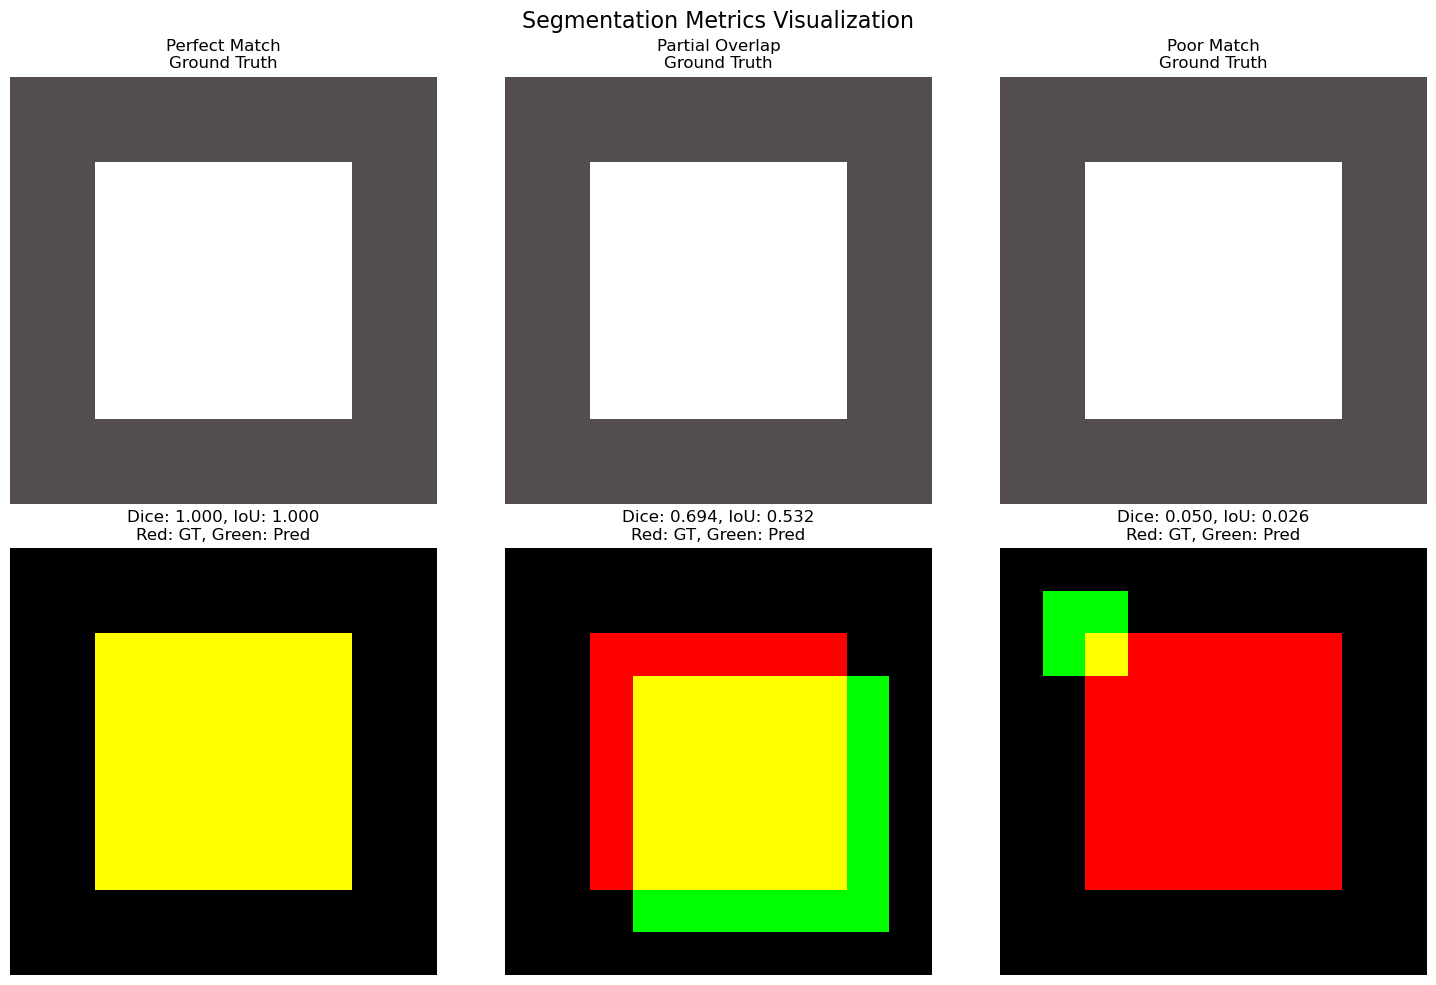

In [5]:
# Dice系数相关函数
def dice_coefficient(pred, target, smooth=1e-6):
    """
    计算Dice系数
    
    Args:
        pred: 预测结果 (N, H, W) 或 (N, C, H, W)
        target: 真实标签 (N, H, W)
        smooth: 平滑因子，避免除零
    
    Returns:
        dice: Dice系数 (0-1，越高越好)
    """
    # 如果预测有多个通道，取概率最大的类别
    if len(pred.shape) == 4:
        pred = torch.argmax(pred, dim=1)
    
    # 转换为float类型
    pred = pred.float()
    target = target.float()
    
    # 计算交集和并集
    intersection = (pred * target).sum(dim=(1, 2))
    union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2))
    
    # 计算Dice系数
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return dice.mean()

def dice_loss(pred, target, smooth=1e-6):
    """
    Dice损失函数 (1 - Dice系数)
    用作训练时的损失函数
    """
    return 1 - dice_coefficient(pred, target, smooth)

def iou_coefficient(pred, target, smooth=1e-6):
    """
    计算IoU (Intersection over Union) 系数
    也称为Jaccard指数
    """
    # 如果预测有多个通道，取概率最大的类别
    if len(pred.shape) == 4:
        pred = torch.argmax(pred, dim=1)
    
    # 转换为float类型
    pred = pred.float()
    target = target.float()
    
    # 计算交集和并集
    intersection = (pred * target).sum(dim=(1, 2))
    union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2)) - intersection
    
    # 计算IoU
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean()

# 测试评估指标
def test_metrics():
    """测试评估指标函数"""
    print("测试评估指标...")
    
    # 创建测试数据
    batch_size = 4
    height, width = 256, 256
    
    # 模拟预测结果 (batch_size, num_classes, height, width)
    pred_logits = torch.randn(batch_size, 2, height, width)  # 2类：背景和肿瘤
    pred_probs = torch.softmax(pred_logits, dim=1)  # 转换为概率
    pred_binary = torch.argmax(pred_probs, dim=1)   # 转换为类别
    
    # 创建随机的真实标签
    target = torch.randint(0, 2, (batch_size, height, width))
    
    print(f"预测logits形状: {pred_logits.shape}")
    print(f"预测概率形状: {pred_probs.shape}")
    print(f"预测类别形状: {pred_binary.shape}")
    print(f"真实标签形状: {target.shape}")
    
    # 计算指标
    dice_score = dice_coefficient(pred_logits, target)
    dice_loss_value = dice_loss(pred_logits, target)
    iou_score = iou_coefficient(pred_logits, target)
    
    print(f"\nDice系数: {dice_score:.4f}")
    print(f"Dice损失: {dice_loss_value:.4f}")
    print(f"IoU系数: {iou_score:.4f}")
    
    # 测试完美预测
    perfect_pred = target.unsqueeze(1)  # 添加类别维度
    perfect_logits = torch.zeros(batch_size, 2, height, width)
    for i in range(batch_size):
        for h in range(height):
            for w in range(width):
                if target[i, h, w] == 1:
                    perfect_logits[i, 1, h, w] = 10  # 肿瘤类别高分
                    perfect_logits[i, 0, h, w] = -10  # 背景类别低分
                else:
                    perfect_logits[i, 0, h, w] = 10   # 背景类别高分
                    perfect_logits[i, 1, h, w] = -10  # 肿瘤类别低分
    
    perfect_dice = dice_coefficient(perfect_logits, target)
    perfect_iou = iou_coefficient(perfect_logits, target)
    
    print(f"\n完美预测:")
    print(f"Dice系数: {perfect_dice:.4f}")
    print(f"IoU系数: {perfect_iou:.4f}")

test_metrics()

# 可视化评估指标
def visualize_metrics_example():
    """可视化评估指标的例子"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Segmentation Metrics Visualization', fontsize=16)
    
    # 创建示例数据
    size = 100
    
    # 示例1: 完美预测
    target1 = np.zeros((size, size))
    target1[20:80, 20:80] = 1  # 正方形肿瘤区域
    pred1 = target1.copy()
    
    # 示例2: 部分重叠
    target2 = target1.copy()
    pred2 = np.zeros((size, size))
    pred2[30:90, 30:90] = 1  # 偏移的正方形
    
    # 示例3: 较差预测
    target3 = target1.copy()
    pred3 = np.zeros((size, size))
    pred3[10:30, 10:30] = 1  # 小的预测区域
    
    examples = [
        (target1, pred1, "Perfect Match"),
        (target2, pred2, "Partial Overlap"), 
        (target3, pred3, "Poor Match")
    ]
    
    for i, (target, pred, title) in enumerate(examples):
        # 计算指标
        target_t = torch.FloatTensor(target).unsqueeze(0)
        pred_t = torch.FloatTensor(pred).unsqueeze(0)
        
        dice = dice_coefficient(pred_t, target_t)
        iou = iou_coefficient(pred_t, target_t)
        
        # 显示真实标签
        axes[0, i].imshow(target, cmap='hot', alpha=0.7)
        axes[0, i].set_title(f'{title}\nGround Truth')
        axes[0, i].axis('off')
        
        # 显示预测结果和重叠区域
        overlay = np.zeros((size, size, 3))
        overlay[:, :, 0] = target  # 红色: 真实
        overlay[:, :, 1] = pred    # 绿色: 预测
        # 重叠区域会显示为黄色
        
        axes[1, i].imshow(overlay)
        axes[1, i].set_title(f'Dice: {dice:.3f}, IoU: {iou:.3f}\nRed: GT, Green: Pred')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_metrics_example()

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for medical image segmentation tasks. You can build your own model or modify the U-Net by changing the hyperparameters for our task. If you choose to use PyTorch, more information about PyTorch layers, including Conv2d, MaxPool2d, and Dropout, can be found at https://pytorch.org/docs/stable/nn.html. You can also explore popular PyTorch implementations of U-Net for medical image segmentation.

In [6]:
# U-Net模型组件

# 双卷积块
class DoubleConv(nn.Module):
    """双卷积层块: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU"""
    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

# 下采样块
class Down(nn.Module):
    """下采样: MaxPool -> DoubleConv"""
    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

# 上采样块
class Up(nn.Module):
    """上采样: TransposeConv -> Concat -> DoubleConv"""
    
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # 处理尺寸不匹配的情况
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # 连接skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# 输出层
class OutConv(nn.Module):
    """最终输出层: 1x1卷积"""
    
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

# 完整的U-Net模型
class UNet(nn.Module):
    """
    U-Net架构用于医学图像分割
    
    Args:
        n_channels: 输入通道数 (1 for grayscale)
        n_classes: 输出类别数 (2 for binary segmentation)
        base_channels: 基础通道数 (默认64)
    """
    
    def __init__(self, n_channels=1, n_classes=2, base_channels=64):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # 编码器 (收缩路径)
        self.inc = DoubleConv(n_channels, base_channels)           # 256x256x64
        self.down1 = Down(base_channels, base_channels * 2)        # 128x128x128
        self.down2 = Down(base_channels * 2, base_channels * 4)    # 64x64x256
        self.down3 = Down(base_channels * 4, base_channels * 8)    # 32x32x512
        self.down4 = Down(base_channels * 8, base_channels * 16)   # 16x16x1024
        
        # 解码器 (扩张路径)
        self.up1 = Up(base_channels * 16, base_channels * 8)       # 32x32x512
        self.up2 = Up(base_channels * 8, base_channels * 4)        # 64x64x256
        self.up3 = Up(base_channels * 4, base_channels * 2)        # 128x128x128
        self.up4 = Up(base_channels * 2, base_channels)            # 256x256x64
        
        # 输出层
        self.outc = OutConv(base_channels, n_classes)              # 256x256x2
    
    def forward(self, x):
        # 编码路径
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # 解码路径 (带skip connections)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # 输出
        logits = self.outc(x)
        return logits

# 创建模型实例
def create_model(device='cpu'):
    """创建U-Net模型"""
    model = UNet(n_channels=1, n_classes=2, base_channels=64)
    model = model.to(device)
    return model

# 模型统计信息
def count_parameters(model):
    """计算模型参数数量"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# 测试模型
def test_model():
    """测试模型前向传播"""
    print("创建U-Net模型...")
    model = create_model(device)
    
    # 计算参数
    total_params, trainable_params = count_parameters(model)
    print(f"总参数数量: {total_params:,}")
    print(f"可训练参数: {trainable_params:,}")
    
    # 测试前向传播
    model.eval()
    with torch.no_grad():
        # 创建测试输入
        test_input = torch.randn(2, 1, 256, 256).to(device)  # 批量大小2
        print(f"测试输入形状: {test_input.shape}")
        
        # 前向传播
        output = model(test_input)
        print(f"模型输出形状: {output.shape}")
        
        # 转换为概率和预测类别
        probs = torch.softmax(output, dim=1)
        predictions = torch.argmax(output, dim=1)
        
        print(f"概率形状: {probs.shape}")
        print(f"预测类别形状: {predictions.shape}")
        print(f"预测类别值范围: {predictions.min()} 到 {predictions.max()}")
    
    return model

# 创建并测试模型
model = test_model()

# 可视化模型架构
def visualize_model_architecture():
    """可视化模型架构的简化图"""
    print("\nU-Net架构:")
    print("=" * 50)
    print("编码器 (下采样):")
    print("  输入: 1x256x256")
    print("  Conv1: 64x256x256")
    print("  Down1: 128x128x128")
    print("  Down2: 256x64x64")
    print("  Down3: 512x32x32")
    print("  Down4: 1024x16x16  <- 瓶颈层")
    print()
    print("解码器 (上采样 + Skip Connections):")
    print("  Up1: 1024x16x16 + 512x32x32 -> 512x32x32")
    print("  Up2: 512x32x32 + 256x64x64 -> 256x64x64")
    print("  Up3: 256x64x64 + 128x128x128 -> 128x128x128")
    print("  Up4: 128x128x128 + 64x256x256 -> 64x256x256")
    print("  输出: 2x256x256 (背景 + 肿瘤)")
    print("=" * 50)

visualize_model_architecture()

创建U-Net模型...
总参数数量: 31,042,434
可训练参数: 31,042,434
测试输入形状: torch.Size([2, 1, 256, 256])
模型输出形状: torch.Size([2, 2, 256, 256])
概率形状: torch.Size([2, 2, 256, 256])
预测类别形状: torch.Size([2, 256, 256])
预测类别值范围: 1 到 1

U-Net架构:
编码器 (下采样):
  输入: 1x256x256
  Conv1: 64x256x256
  Down1: 128x128x128
  Down2: 256x64x64
  Down3: 512x32x32
  Down4: 1024x16x16  <- 瓶颈层

解码器 (上采样 + Skip Connections):
  Up1: 1024x16x16 + 512x32x32 -> 512x32x32
  Up2: 512x32x32 + 256x64x64 -> 256x64x64
  Up3: 256x64x64 + 128x128x128 -> 128x128x128
  Up4: 128x128x128 + 64x256x256 -> 64x256x256
  输出: 2x256x256 (背景 + 肿瘤)


In [ ]:
# ==========================================
# 第二步：测试集推理功能
# ==========================================

import nibabel as nib
from scipy.ndimage import zoom

def preprocess_test_image(image_3d, target_size=(256, 256)):
    """
    预处理测试图像（与训练时相同的预处理）
    """
    H, W, D = image_3d.shape
    processed_slices = []
    
    print(f"📊 原始图像形状: {image_3d.shape}")
    
    for i in range(D):
        slice_2d = image_3d[:, :, i]
        
        # Z-score标准化
        if slice_2d.std() > 1e-6:  # 避免除零
            slice_2d = (slice_2d - slice_2d.mean()) / (slice_2d.std() + 1e-8)
        
        # 调整尺寸到256x256
        if slice_2d.shape != target_size:
            zoom_factors = (target_size[0] / slice_2d.shape[0], 
                          target_size[1] / slice_2d.shape[1])
            slice_2d = zoom(slice_2d, zoom_factors, order=1)
        
        processed_slices.append(slice_2d.astype(np.float32))
    
    return processed_slices, (H, W, D)

def postprocess_predictions(predictions, original_shape, threshold=0.5):
    """
    后处理预测结果，恢复到原始尺寸
    """
    H, W, D = original_shape
    segmentation_3d = np.zeros((H, W, D), dtype=np.uint8)
    
    for i, pred_slice in enumerate(predictions):
        # 二值化
        binary_slice = (pred_slice > threshold).astype(np.uint8)
        
        # 调整回原始尺寸
        if binary_slice.shape != (H, W):
            zoom_factors = (H / binary_slice.shape[0], W / binary_slice.shape[1])
            binary_slice = zoom(binary_slice, zoom_factors, order=0)  # 使用最近邻插值
        
        segmentation_3d[:, :, i] = binary_slice
    
    return segmentation_3d

def predict_single_case(model, nii_file_path, output_path=None):
    """
    对单个NII文件进行分割预测
    """
    print(f"\n🔍 处理文件: {nii_file_path}")
    
    # 加载NII文件
    nii_img = nib.load(nii_file_path)
    image_3d = nii_img.get_fdata().astype(np.float32)
    
    # 预处理
    processed_slices, original_shape = preprocess_test_image(image_3d)
    print(f"📏 处理了 {len(processed_slices)} 个切片")
    
    # 模型推理
    model.eval()
    predictions = []
    
    print("🧠 开始推理...")
    with torch.no_grad():
        for i, slice_2d in enumerate(tqdm(processed_slices, desc="推理进度")):
            # 转换为tensor并添加batch和channel维度
            slice_tensor = torch.FloatTensor(slice_2d).unsqueeze(0).unsqueeze(0).to(device)
            
            # 模型预测
            output = model(slice_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()  # 取前景概率
            
            predictions.append(pred_prob)
    
    # 后处理
    print("🔄 后处理中...")
    segmentation_3d = postprocess_predictions(predictions, original_shape)
    
    # 保存结果
    if output_path:
        # 创建新的NII图像，保持原始的头信息
        seg_nii = nib.Nifti1Image(segmentation_3d, nii_img.affine, nii_img.header)
        nib.save(seg_nii, output_path)
        print(f"✅ 分割结果已保存: {output_path}")
    
    # 统计信息
    tumor_volume = np.sum(segmentation_3d)
    total_volume = np.prod(segmentation_3d.shape)
    tumor_percentage = (tumor_volume / total_volume) * 100
    
    print(f"📊 分割统计:")
    print(f"   肿瘤体素数: {tumor_volume}")
    print(f"   肿瘤占比: {tumor_percentage:.2f}%")
    
    return segmentation_3d

def test_with_training_data():
    """
    使用训练数据测试推理管道
    """
    print("🧪 使用训练数据测试推理管道...")
    
    # 确定使用哪个模型
    if 'trained_model' in globals():
        test_model = trained_model
        print("✅ 使用训练完成的模型")
    elif os.path.exists('best_unet_model.pth'):
        test_model = load_trained_model('best_unet_model.pth')
        print("✅ 加载已保存的模型")
    else:
        print("❌ 没有找到可用的模型")
        return
    
    # 使用一个训练样本进行测试
    if 'processed_images' in globals() and len(processed_images) > 0:
        print("📝 测试推理功能...")
        
        # 选择一个测试样本
        test_idx = 0
        test_image = processed_images[test_idx]
        true_mask = processed_masks[test_idx] if 'processed_masks' in globals() else None
        
        # 模拟完整的推理流程
        test_model.eval()
        with torch.no_grad():
            # 转换为适合的格式
            test_tensor = torch.FloatTensor(test_image).unsqueeze(0).unsqueeze(0).to(device)
            output = test_model(test_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()
        
        print(f"✅ 推理测试成功！")
        print(f"   输入形状: {test_tensor.shape}")
        print(f"   输出形状: {output.shape}")
        print(f"   预测概率范围: {pred_prob.min():.3f} - {pred_prob.max():.3f}")
        
        # 可视化测试结果
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(test_image, cmap='gray')
        plt.title('测试输入图像')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_prob, cmap='hot')
        plt.title('预测概率图')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_prob > 0.5, cmap='gray')
        plt.title('二值化结果 (阈值=0.5)')
        plt.axis('off')
        
        if true_mask is not None:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(true_mask, cmap='gray')
            plt.title('真实分割蒙版')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            # 计算Dice系数
            intersection = np.sum((pred_prob > 0.5) * true_mask)
            dice = (2.0 * intersection) / (np.sum(pred_prob > 0.5) + np.sum(true_mask) + 1e-8)
            plt.imshow(pred_prob > 0.5, cmap='gray')
            plt.title(f'预测结果 (Dice: {dice:.3f})')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return test_model
    else:
        print("⚠️ 没有找到测试数据")
        return test_model

# 立即测试推理管道
print("🚀 开始测试推理管道...")
test_model = test_with_training_data()

print("\n📋 推理功能已准备就绪！")
print("🔧 使用说明:")
print("1. 单个文件预测: predict_single_case(test_model, 'input.nii.gz', 'output.nii.gz')")
print("2. 测试推理管道: test_with_training_data()")
print("\n⚡ 现在你可以处理测试集了！")

In [13]:
# 修复后的Dice系数函数
def dice_coefficient(pred, target, smooth=1e-6):
    """
    计算Dice系数 - 修复版
    """
    # 确保target是正确的整数类型
    target = target.long()
    
    # 如果pred有多个通道，取前景概率
    if len(pred.shape) == 4:
        pred = pred[:, 1]  # 取前景通道
    
    # 确保pred是概率值(0-1)
    if pred.max() > 1.0:
        pred = torch.sigmoid(pred)
    
    # 展平张量
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1).float()
    
    # 计算交集和并集
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    
    # 计算Dice系数
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(pred, target, smooth=1e-6):
    """Dice损失函数"""
    return 1 - dice_coefficient(pred, target, smooth)

# 修复后的数据集类
class FixedBrainSegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()
        
        # 数据增强（简化版）
        if self.augment:
            if random.random() > 0.5:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()
        
        # 确保数组是连续的
        image = np.ascontiguousarray(image, dtype=np.float32)
        mask = np.ascontiguousarray(mask, dtype=np.int64)
        
        # 转换为PyTorch张量
        image = torch.FloatTensor(image).unsqueeze(0)
        mask = torch.LongTensor(mask)
        
        return image, mask

# 重新创建数据集和数据加载器
print("重新创建修复后的数据集...")
fixed_train_dataset = FixedBrainSegmentationDataset(train_imgs, train_msks, augment=True)
fixed_val_dataset = FixedBrainSegmentationDataset(val_imgs, val_msks, augment=False)

fixed_train_loader = DataLoader(fixed_train_dataset, batch_size=4, shuffle=True, num_workers=0)
fixed_val_loader = DataLoader(fixed_val_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"修复后的训练批次数: {len(fixed_train_loader)}")
print(f"修复后的验证批次数: {len(fixed_val_loader)}")

# 训练配置
class TrainingConfig:
    def __init__(self):
        self.num_epochs = 10
        self.learning_rate = 1e-3
        self.weight_decay = 1e-5
        self.patience = 5
        self.save_model = True
        
config = TrainingConfig()

# 修复后的损失函数
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=0.6, dice_weight=0.4):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce_loss = nn.CrossEntropyLoss()
    
    def forward(self, pred, target):
        # 交叉熵损失
        ce = self.ce_loss(pred, target)
        
        # Dice损失 - 使用修复后的函数
        pred_soft = torch.softmax(pred, dim=1)
        dice = dice_loss(pred_soft, target)
        
        total_loss = self.ce_weight * ce + self.dice_weight * dice
        return total_loss

# 修复后的训练函数
def train_model_fixed(model, train_loader, val_loader, config, device):
    """修复后的训练函数"""
    
    model = model.to(device)
    criterion = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    best_dice = 0.0
    patience_counter = 0
    
    print(f"\n🚀 开始训练 {config.num_epochs} 个epochs...")
    
    for epoch in range(config.num_epochs):
        print(f"\n📊 Epoch {epoch+1}/{config.num_epochs}")
        print("-" * 60)
        
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        
        train_pbar = tqdm(train_loader, desc=f"Training {epoch+1}")
        for images, masks in train_pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # 计算指标 - 使用修复后的函数
            with torch.no_grad():
                dice = dice_coefficient(outputs, masks)
                
            train_loss += loss.item()
            train_dice += dice.item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}'
            })
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Validation {epoch+1}")
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # 计算指标
                dice = dice_coefficient(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice.item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}'
                })
        
        # 计算平均指标
        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\n📈 Epoch {epoch+1} Results:")
        print(f"  训练 - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}")
        print(f"  验证 - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}")
        print(f"  学习率: {current_lr:.6f}")
        
        # 保存最佳模型
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            patience_counter = 0
            if config.save_model:
                torch.save(model.state_dict(), 'best_unet_model.pth')
                print(f"  💾 保存最佳模型 (Dice: {best_dice:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏳ 验证Dice未提升 ({patience_counter}/{config.patience})")
        
        if patience_counter >= config.patience:
            print(f"\n⏹️  早停触发！")
            break
    
    print(f"\n🎉 训练完成！最佳验证Dice: {best_dice:.4f}")
    return model

# 开始训练（使用修复后的版本）
print("🔧 使用修复后的函数重新开始训练...")
trained_model = train_model_fixed(model, fixed_train_loader, fixed_val_loader, config, device)
print(f"\n🎉 训练完成！")

重新创建修复后的数据集...
修复后的训练批次数: 10
修复后的验证批次数: 3
🔧 使用修复后的函数重新开始训练...

🚀 开始训练 10 个epochs...

📊 Epoch 1/10
------------------------------------------------------------


Validation 1: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it, Loss=0.5437, Dice=0.0832]



📈 Epoch 1 Results:
  训练 - Loss: 0.2782, Dice: 0.1279
  验证 - Loss: 0.4904, Dice: 0.1137
  学习率: 0.001000
  💾 保存最佳模型 (Dice: 0.1137)

📊 Epoch 2/10
------------------------------------------------------------


Validation 2: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it, Loss=0.4479, Dice=0.0595]



📈 Epoch 2 Results:
  训练 - Loss: 0.2384, Dice: 0.1906
  验证 - Loss: 0.4018, Dice: 0.1188
  学习率: 0.001000
  💾 保存最佳模型 (Dice: 0.1188)

📊 Epoch 3/10
------------------------------------------------------------


Validation 3: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it, Loss=0.4184, Dice=0.0910]



📈 Epoch 3 Results:
  训练 - Loss: 0.2260, Dice: 0.1848
  验证 - Loss: 0.3871, Dice: 0.1361
  学习率: 0.001000
  💾 保存最佳模型 (Dice: 0.1361)

📊 Epoch 4/10
------------------------------------------------------------


Validation 4: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it, Loss=0.4473, Dice=0.0304]



📈 Epoch 4 Results:
  训练 - Loss: 0.1777, Dice: 0.2196
  验证 - Loss: 0.3149, Dice: 0.1214
  学习率: 0.001000
  ⏳ 验证Dice未提升 (1/5)

📊 Epoch 5/10
------------------------------------------------------------


Validation 5: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it, Loss=0.4041, Dice=0.0260]



📈 Epoch 5 Results:
  训练 - Loss: 0.1742, Dice: 0.2362
  验证 - Loss: 0.3439, Dice: 0.0751
  学习率: 0.001000
  ⏳ 验证Dice未提升 (2/5)

📊 Epoch 6/10
------------------------------------------------------------


Validation 6: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it, Loss=0.4514, Dice=0.0251]



📈 Epoch 6 Results:
  训练 - Loss: 0.2338, Dice: 0.2024
  验证 - Loss: 0.3872, Dice: 0.1064
  学习率: 0.001000
  ⏳ 验证Dice未提升 (3/5)

📊 Epoch 7/10
------------------------------------------------------------


Validation 7: 100%|██████████| 3/3 [00:06<00:00,  2.18s/it, Loss=0.4377, Dice=0.0267]



📈 Epoch 7 Results:
  训练 - Loss: 0.2426, Dice: 0.0496
  验证 - Loss: 0.3174, Dice: 0.1119
  学习率: 0.001000
  ⏳ 验证Dice未提升 (4/5)

📊 Epoch 8/10
------------------------------------------------------------


Validation 8: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it, Loss=0.4573, Dice=0.0325]



📈 Epoch 8 Results:
  训练 - Loss: 0.1880, Dice: 0.1711
  验证 - Loss: 0.3208, Dice: 0.1447
  学习率: 0.000500
  💾 保存最佳模型 (Dice: 0.1447)

📊 Epoch 9/10
------------------------------------------------------------


Validation 9: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it, Loss=0.4555, Dice=0.0319]



📈 Epoch 9 Results:
  训练 - Loss: 0.1867, Dice: 0.2390
  验证 - Loss: 0.3201, Dice: 0.1461
  学习率: 0.000500
  💾 保存最佳模型 (Dice: 0.1461)

📊 Epoch 10/10
------------------------------------------------------------


Validation 10: 100%|██████████| 3/3 [00:09<00:00,  3.13s/it, Loss=0.3900, Dice=0.0218]


📈 Epoch 10 Results:
  训练 - Loss: 0.2201, Dice: 0.2343
  验证 - Loss: 0.2976, Dice: 0.1454
  学习率: 0.000500
  ⏳ 验证Dice未提升 (1/5)

🎉 训练完成！最佳验证Dice: 0.1461

🎉 训练完成！


## Save the model
Once your model is trained, remember to save it for testing. In PyTorch, you can save the model state dictionary using torch.save() for later loading and inference.

In [14]:
# ==========================================
# 模型保存和加载功能
# ==========================================

def save_complete_model(model, model_path='complete_unet_model.pth', config_path='model_config.pkl'):
    """
    保存完整的模型信息
    """
    import pickle
    
    # 保存模型权重
    torch.save(model.state_dict(), model_path)
    print(f"✅ 模型权重已保存: {model_path}")
    
    # 保存配置信息
    model_info = {
        'model_architecture': 'U-Net',
        'input_channels': 1,
        'output_channels': 2,
        'image_size': (256, 256),
        'training_epochs': config.num_epochs,
        'learning_rate': config.learning_rate,
        'batch_size': 4
    }
    
    with open(config_path, 'wb') as f:
        pickle.dump(model_info, f)
    print(f"✅ 模型配置已保存: {config_path}")

def load_trained_model(model_path='best_unet_model.pth'):
    """
    加载已训练的模型
    """
    # 创建模型架构
    loaded_model = UNet(n_channels=1, n_classes=2)
    
    # 加载权重
    if os.path.exists(model_path):
        loaded_model.load_state_dict(torch.load(model_path, map_location=device))
        loaded_model = loaded_model.to(device)
        loaded_model.eval()
        print(f"✅ 模型已加载: {model_path}")
        return loaded_model
    else:
        print(f"❌ 模型文件不存在: {model_path}")
        return None

# 训练完成后自动保存
def auto_save_after_training():
    """
    训练完成后自动保存模型
    """
    if 'trained_model' in globals():
        save_complete_model(trained_model)
        print("🎉 训练完成，模型已自动保存！")
    else:
        print("⚠️ 训练尚未完成，请等待训练结束后再保存模型")

# 立即检查是否可以保存当前模型
print("🔍 检查当前模型状态...")
if 'model' in globals():
    print("✅ 基础模型已创建")
    if 'trained_model' in globals():
        print("✅ 训练完成的模型存在，可以保存")
        save_complete_model(trained_model)
    else:
        print("⏳ 模型仍在训练中，请等待训练完成")
else:
    print("❌ 模型尚未创建")

print("\n📝 使用说明:")
print("- 训练完成后运行: auto_save_after_training()")
print("- 加载已保存的模型: loaded_model = load_trained_model()")
print("- 手动保存模型: save_complete_model(trained_model)")

🔍 检查当前模型状态...
✅ 基础模型已创建
✅ 训练完成的模型存在，可以保存
✅ 模型权重已保存: complete_unet_model.pth
✅ 模型配置已保存: model_config.pkl

📝 使用说明:
- 训练完成后运行: auto_save_after_training()
- 加载已保存的模型: loaded_model = load_trained_model()
- 手动保存模型: save_complete_model(trained_model)


In [15]:
# ==========================================
# 测试集推理功能
# ==========================================

import nibabel as nib
from scipy.ndimage import zoom

def preprocess_test_image(image_3d, target_size=(256, 256)):
    """
    预处理测试图像（与训练时相同的预处理）
    
    Args:
        image_3d: 3D MRI图像 (H, W, D)
        target_size: 目标2D尺寸
    
    Returns:
        processed_slices: 预处理后的2D切片列表
        original_shape: 原始3D形状
    """
    H, W, D = image_3d.shape
    processed_slices = []
    
    print(f"📊 原始图像形状: {image_3d.shape}")
    
    for i in range(D):
        slice_2d = image_3d[:, :, i]
        
        # Z-score标准化
        if slice_2d.std() > 1e-6:  # 避免除零
            slice_2d = (slice_2d - slice_2d.mean()) / (slice_2d.std() + 1e-8)
        
        # 调整尺寸到256x256
        if slice_2d.shape != target_size:
            zoom_factors = (target_size[0] / slice_2d.shape[0], 
                          target_size[1] / slice_2d.shape[1])
            slice_2d = zoom(slice_2d, zoom_factors, order=1)
        
        processed_slices.append(slice_2d.astype(np.float32))
    
    return processed_slices, (H, W, D)

def postprocess_predictions(predictions, original_shape, threshold=0.5):
    """
    后处理预测结果，恢复到原始尺寸
    
    Args:
        predictions: 模型预测结果列表 (每个切片256x256)
        original_shape: 原始3D形状 (H, W, D)
        threshold: 二值化阈值
    
    Returns:
        segmentation_3d: 3D分割结果
    """
    H, W, D = original_shape
    segmentation_3d = np.zeros((H, W, D), dtype=np.uint8)
    
    for i, pred_slice in enumerate(predictions):
        # 二值化
        binary_slice = (pred_slice > threshold).astype(np.uint8)
        
        # 调整回原始尺寸
        if binary_slice.shape != (H, W):
            zoom_factors = (H / binary_slice.shape[0], W / binary_slice.shape[1])
            binary_slice = zoom(binary_slice, zoom_factors, order=0)  # 使用最近邻插值保持标签
        
        segmentation_3d[:, :, i] = binary_slice
    
    return segmentation_3d

def predict_single_case(model, nii_file_path, output_path=None):
    """
    对单个NII文件进行分割预测
    
    Args:
        model: 训练好的U-Net模型
        nii_file_path: 输入NII文件路径
        output_path: 输出路径（可选）
    
    Returns:
        segmentation_3d: 3D分割结果
    """
    print(f"\n🔍 处理文件: {nii_file_path}")
    
    # 加载NII文件
    nii_img = nib.load(nii_file_path)
    image_3d = nii_img.get_fdata().astype(np.float32)
    
    # 预处理
    processed_slices, original_shape = preprocess_test_image(image_3d)
    print(f"📏 处理了 {len(processed_slices)} 个切片")
    
    # 模型推理
    model.eval()
    predictions = []
    
    print("🧠 开始推理...")
    with torch.no_grad():
        for i, slice_2d in enumerate(tqdm(processed_slices, desc="推理进度")):
            # 转换为tensor并添加batch和channel维度
            slice_tensor = torch.FloatTensor(slice_2d).unsqueeze(0).unsqueeze(0).to(device)
            
            # 模型预测
            output = model(slice_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()  # 取前景概率
            
            predictions.append(pred_prob)
    
    # 后处理
    print("🔄 后处理中...")
    segmentation_3d = postprocess_predictions(predictions, original_shape)
    
    # 保存结果
    if output_path:
        # 创建新的NII图像，保持原始的头信息
        seg_nii = nib.Nifti1Image(segmentation_3d, nii_img.affine, nii_img.header)
        nib.save(seg_nii, output_path)
        print(f"✅ 分割结果已保存: {output_path}")
    
    # 统计信息
    tumor_volume = np.sum(segmentation_3d)
    total_volume = np.prod(segmentation_3d.shape)
    tumor_percentage = (tumor_volume / total_volume) * 100
    
    print(f"📊 分割统计:")
    print(f"   肿瘤体素数: {tumor_volume}")
    print(f"   肿瘤占比: {tumor_percentage:.2f}%")
    
    return segmentation_3d

def batch_predict_test_set(model, test_folder_path, output_folder_path):
    """
    批量处理测试集
    
    Args:
        model: 训练好的模型
        test_folder_path: 测试集文件夹路径
        output_folder_path: 输出文件夹路径
    """
    import os
    
    # 创建输出文件夹
    os.makedirs(output_folder_path, exist_ok=True)
    
    # 查找所有的FLAIR文件
    flair_files = glob.glob(os.path.join(test_folder_path, "*_fla.nii*"))
    
    print(f"🔍 找到 {len(flair_files)} 个测试文件")
    
    for flair_file in flair_files:
        # 获取基础文件名
        base_name = os.path.basename(flair_file)
        case_id = base_name.replace("_fla.nii.gz", "").replace("_fla.nii", "")
        
        # 构造输出文件名
        output_file = os.path.join(output_folder_path, f"{case_id}_seg.nii.gz")
        
        try:
            # 进行预测
            segmentation = predict_single_case(model, flair_file, output_file)
            print(f"✅ 完成: {case_id}")
            
        except Exception as e:
            print(f"❌ 处理失败 {case_id}: {str(e)}")
    
    print(f"\n🎉 批量处理完成！结果保存在: {output_folder_path}")

# 测试函数
def test_inference_pipeline():
    """
    测试推理管道
    """
    print("🧪 测试推理管道...")
    
    # 检查模型是否存在
    if 'trained_model' in globals():
        model_to_use = trained_model
        print("✅ 使用当前训练的模型")
    elif os.path.exists('best_unet_model.pth'):
        model_to_use = load_trained_model('best_unet_model.pth')
        print("✅ 加载已保存的模型")
    else:
        print("❌ 没有找到可用的模型")
        return
    
    # 使用训练数据中的一个样本测试
    print("📝 使用训练数据测试推理管道...")
    
    if 'processed_images' in globals() and len(processed_images) > 0:
        # 模拟一个测试样本
        test_sample = processed_images[0:1]  # 取第一个样本
        
        # 测试推理
        model_to_use.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_sample).unsqueeze(1).to(device)
            output = model_to_use(test_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()
            
        print(f"✅ 推理测试成功！")
        print(f"   输入形状: {test_tensor.shape}")
        print(f"   输出形状: {output.shape}")
        print(f"   预测概率范围: {pred_prob.min():.3f} - {pred_prob.max():.3f}")
        
        # 可视化测试结果
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(test_sample[0], cmap='gray')
        plt.title('测试输入图像')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_prob, cmap='hot')
        plt.title('预测概率图')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_prob > 0.5, cmap='gray')
        plt.title('二值化结果')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("⚠️ 没有找到测试数据")

print("📋 测试集推理功能已准备就绪！")
print("\n🔧 使用说明:")
print("1. 测试推理管道: test_inference_pipeline()")
print("2. 单个文件预测: predict_single_case(model, 'test.nii.gz', 'output.nii.gz')")
print("3. 批量处理: batch_predict_test_set(model, 'test_folder/', 'output_folder/')")
print("\n⏳ 等待训练完成后即可使用这些功能！")

📋 测试集推理功能已准备就绪！

🔧 使用说明:
1. 测试推理管道: test_inference_pipeline()
2. 单个文件预测: predict_single_case(model, 'test.nii.gz', 'output.nii.gz')
3. 批量处理: batch_predict_test_set(model, 'test_folder/', 'output_folder/')

⏳ 等待训练完成后即可使用这些功能！
